# 基于卷积神经网络的脑电运动成像信号分类
## 数据集
数据来自8个健康的受试者（训练受试者S1～S4，测试受试者S5～S8），每一个受试者执行两类运动想象任务：右手和双脚，脑电信号由一个13通道的脑电帽以512Hz的频率记录得到。我们提供了经过预处理后的数据：下采样到了250Hz，带通滤波至8-32Hz，划分每一次视觉提示出现后的0.5~3.5s之间的EEG信号作为一个trial。每个用户包含200个trial（右手和双脚各100个trial）。
数据以.npz和.mat格式提供，包含：
* X: 预处理后的EEG信号, 维度: [trails * 通道* 采样点]。
* y: 类别标签向量。测试数据不包含此变量。

## 1. 读取数据集
分别读取S1-S4，并将数据集中的X和Y向量分别合并，得到800条数据和对应的标签, 将y向量reshape.
合并后的数据集大小
* data_X: [800, 13, 750]
* data_y: [800， 1]

In [37]:
# Read in Train Data S1~S4
import numpy as np

datafile1 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\train\S1.npz"
datafile2 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\train\S2.npz"
datafile3 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\train\S3.npz"
datafile4 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\train\S4.npz"

dataSet1 = np.load(datafile1)
dataSet2 = np.load(datafile2)
dataSet3 = np.load(datafile3)
dataSet4 = np.load(datafile4)

In [38]:
# Concatenate Datasets X

data_X = np.concatenate([dataSet1['X'], dataSet2['X']], axis = 0)

data_X = np.concatenate([data_X, dataSet3['X']], axis = 0)

data_X = np.concatenate([data_X, dataSet4['X']], axis = 0)

print('====== Dataset Train S1~S4 -> X ======')
print('Type:', type(data_X))
print('Dimision:', data_X.ndim)
print('Shape:', data_X.shape)

====== Dataset Train S1~S4 -> X ======
Type: <class 'numpy.ndarray'>
Dimision: 3
Shape: (800, 13, 750)


In [39]:
# Concatenate Datasets y

data_y = np.concatenate([dataSet1['y'], dataSet2['y']], axis = 0)

data_y = np.concatenate([data_y, dataSet3['y']], axis = 0)

data_y = np.concatenate([data_y, dataSet4['y']], axis = 0)

# Reshape
data_y = data_y.reshape((800, 1))

print('===== Dataset Train S1~S4 -> Lable(y) =====')
# lableTrain = np.reshape(lableTrain, (1, 800))
# print(lableTrain)

print('Type:', type(data_y))
print('Dimision:', data_y.ndim)
print('Shape:', data_y.shape)

===== Dataset Train S1~S4 -> Lable(y) =====
Type: <class 'numpy.ndarray'>
Dimision: 2
Shape: (800, 1)


## 2. 可视化处理
对一条数据的两个通道数据进行可视化处理以观察数据的趋势, 选用trail-1的channel-1和channel-2

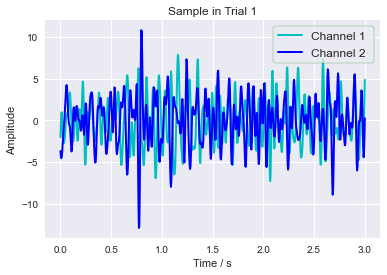

In [40]:
# Visualization
%matplotlib inline
import matplotlib.pyplot as plt

sampleRate = 250 # Sample Rate = 250Hz

# X Axis
t = np.linspace(0, data_X.shape[2] / sampleRate, data_X.shape[2])

# Sample Line
L1 = data_X[0, 0, :]
L2 = data_X[1, 0, :]

# Plot
plt.style.use('seaborn-colorblind')
plt.title("Sample in Trial 1")
plt.xlabel('Time / s')
plt.ylabel('Amplitude') # 振幅

plt.plot(t, L1, 'c-', linewidth= 2, label='Channel 1 ')
plt.plot(t, L2, 'b-', linewidth = 2, label='Channel 2')

plt.legend(loc='upper right',fontsize='large',frameon=True,edgecolor='green')

## 3. CNN 模型搭建
利用 CNN 模型对数据集进行分类学习

### 3.1 1D-LeNet 模型

#### 3.1.1 1D-LeNet 模型搭建

<img src="https://www.researchgate.net/publication/344128059/figure/fig1/AS:1021719754072066@1620608380536/The-architecture-of-1D-LeNet-5.png" width="20%">

In [41]:
## CNN Model
# LeNet Using pytorch

import torch
import torch.nn as nn
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(13, 3, 25), # in_channels, out_channels, kernel_size
            nn.Sigmoid(),
            nn.AvgPool1d(2), # kernel_size, stride
            nn.Conv1d(3, 1, 25),
            nn.Sigmoid(),
            nn.AvgPool1d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(169, 120),
            nn.Sigmoid(),
            # Add a Dropout Layer
            nn.Dropout(p=0.5),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 2)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature)
        return output


#### 3.1.2 使用 Torch Summary 打印模型
Pytorch Summary: https://github.com/sksq96/pytorch-summary

In [42]:
device = torch.device("cpu")
model = LeNet().to(device)
summary(model, (13, 750) , device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 3, 726]             978
           Sigmoid-2               [-1, 3, 726]               0
         AvgPool1d-3               [-1, 3, 363]               0
            Conv1d-4               [-1, 1, 339]              76
           Sigmoid-5               [-1, 1, 339]               0
         AvgPool1d-6               [-1, 1, 169]               0
            Linear-7               [-1, 1, 120]          20,400
           Sigmoid-8               [-1, 1, 120]               0
           Dropout-9               [-1, 1, 120]               0
           Linear-10                [-1, 1, 84]          10,164
          Sigmoid-11                [-1, 1, 84]               0
           Linear-12                 [-1, 1, 2]             170
Total params: 31,788
Trainable params: 31,788
Non-trainable params: 0
---------------------------------

#### 3.1.3 定义训练和模型评估函数

In [43]:
import time

# 定义list储存训练中的结果
losslist=[]
train_acc_list = []
test_acc_list = []

# 模型训练
def train(net, data_x, data_y, optimizer, device, num_epochs):
    net = net.to(device)
    print("======= Training on", device, "=======")
    loss = torch.nn.MSELoss()
    loss=torch.nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        # 划分训练集和验证集
        train_data, test_data, train_label, test_label = \
            train_test_split(data_X, data_y, test_size=0.7, random_state = 41)

        train_l_sum, train_acc_sum, n, batch_count, start = \
            0.0, 0.0, 0, 0, time.time()

        for X, y in zip(train_data,train_label):
            X = torch.Tensor(X)
            y = torch.LongTensor(y)
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_data, test_label, net)
        print('Epoch: %d, Loss: %.4f, Train acc: %.3f, Test acc: %.3f, Time: %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
        losslist.append(train_l_sum / batch_count)
        train_acc_list.append(train_acc_sum / n)
        test_acc_list.append(test_acc)

# 模型评估
def evaluate_accuracy(data_iter, label_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in zip(data_iter,label_iter):
            X = torch.Tensor(X)
            y = torch.Tensor(y)
            #print(X.shape);input()
            net.eval() # 评估模式, 这会关闭dropout
            acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
            net.train() # 改回训练模式
            n += y.shape[0]
    return acc_sum / n

#### 3.1.4 对 1D-LeNet 模型进行实例化并训练

======= Training on cpu =======
Epoch: 1, Loss: 0.7022, Train acc: 0.567, Test acc: 0.495, Time: 1.6 sec
Epoch: 2, Loss: 0.6953, Train acc: 0.554, Test acc: 0.495, Time: 0.8 sec
Epoch: 3, Loss: 0.6924, Train acc: 0.550, Test acc: 0.495, Time: 0.7 sec
Epoch: 4, Loss: 0.6938, Train acc: 0.554, Test acc: 0.495, Time: 0.8 sec
Epoch: 5, Loss: 0.6911, Train acc: 0.546, Test acc: 0.495, Time: 0.7 sec
Epoch: 6, Loss: 0.6969, Train acc: 0.571, Test acc: 0.487, Time: 0.7 sec
Epoch: 7, Loss: 0.6940, Train acc: 0.571, Test acc: 0.516, Time: 0.8 sec
Epoch: 8, Loss: 0.6855, Train acc: 0.558, Test acc: 0.527, Time: 0.8 sec
Epoch: 9, Loss: 0.6842, Train acc: 0.550, Test acc: 0.511, Time: 0.9 sec
Epoch: 10, Loss: 0.6639, Train acc: 0.608, Test acc: 0.489, Time: 0.8 sec
Epoch: 11, Loss: 0.6358, Train acc: 0.658, Test acc: 0.505, Time: 0.9 sec
Epoch: 12, Loss: 0.6224, Train acc: 0.671, Test acc: 0.498, Time: 0.9 sec
Epoch: 13, Loss: 0.5650, Train acc: 0.725, Test acc: 0.507, Time: 1.0 sec
Epoch: 14, Loss

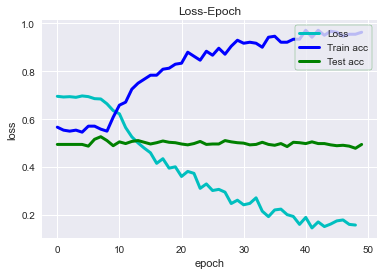

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

input_shape = data_X.shape[1], data_X.shape[2] # (13, 750)
lable_shape = data_y.shape # (800, 1)

# Build Model
net = LeNet()
lr = 0.001
num_epochs = 50
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
train(net, data_X, data_y, optimizer, device, num_epochs)

# Draw Loss-Epoch Diagram
plt.style.use('seaborn-colorblind')
plt.title('Loss-Epoch')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.plot(losslist[1:], 'c-', linewidth= 3, label='Loss')
plt.plot(train_acc_list, 'b-', linewidth = 3, label='Train acc')
plt.plot(test_acc_list, 'g-', linewidth = 3, label='Test acc')

plt.legend(loc='upper right',fontsize='medium',frameon=True,edgecolor='green')
plt.show()
plt.close()

可以发现，该模型在训练过程中出现了过拟合，训练集准确率可以达到接近100%, 但测试集的准确率只有约50%. 因此其网络结构对该数据集不可靠。

### 3.2 EEG-Inception Neural Network


#### 3.2.1 EEG-Inception Neural Network 模型搭建
https://doi.org/10.1109/TNSRE.2020.3048106

In [45]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Activation, Input, Flatten
from keras.layers import Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, DepthwiseConv1D
from keras.layers import Dense
from keras.layers import Concatenate

def EEGInception(data_num = 750,
                 channel_num = 13,
                 sample_rate = 250,
                 filters_per_branch = 13,
                 dropout_rate = 0.25,
                 activation = 'ReLU',
                 n_classes = 2,
                 learning_rate = 0.001
                 ):

    # The extracted features from the EEG signal are based on
    # [0.1s, 0.3s, 0.5s, 0.7s, 0.9s]
    # scales_time = [0, 100, 300, 500, 700, 900]
    kernel_size = [0, 25, 50, 75]
    # for i in range(1, 5):
    #     kernel_size[i] = scales_time[i] * sample_rate / 1000
    # kernel_size[0] = 0
    # print('Kernel Size List:', kernel_size) # [0, 25, 50, 75]

    # the max-pooling is applied to select
    # the maximum feature from the input data with a kernel size of
    # twenty-five (0.1 seconds)
    # pool_size = int(100 * sample_rate / 1000) # 0.1s
    # print('Pool Size:', pool_size) # 25

    # ================================ INPUT Layer ================================= #
    # Input Data
    input_layer = Input(shape = (data_num , channel_num))

    # ========================== BLOCK 1: INCEPTION ========================== #

    # Convolution Layer [1] with kernel size [25]
    output_Conv1 = Conv1D(filters = filters_per_branch,
                          kernel_size = kernel_size[1],
                          kernel_initializer='he_normal',
                          use_bias=False,
                          padding='same')(input_layer)

    # Convolution Layer [2] with kernel size [50]
    output_Conv2 = Conv1D(filters = filters_per_branch,
                          kernel_size = kernel_size[2],
                          kernel_initializer='he_normal',
                          use_bias=False,
                          padding='same')(input_layer)

    # Convolution Layer [3] with kernel size [75]
    output_Conv3 = Conv1D(filters = filters_per_branch,
                          kernel_size = kernel_size[3],
                          kernel_initializer='he_normal',
                          use_bias=False,
                          padding='same')(input_layer)


    # Concanetate 3 Convolution Layers and a MaxPooling Layer
    output_Concanetate = Concatenate(axis = -1)([output_Conv1, output_Conv2])
    output_Concanetate = Concatenate(axis = -1)([output_Concanetate, output_Conv3])

    output_BN = BatchNormalization()(output_Concanetate)
    output_Activation = Activation('ReLU')(output_BN)
    data_output1 = output_Activation

    # ========================== BLOCK 2: INCEPTION ========================== #


    # Convolution Layer [1] with kernel size [25]
    output1_Conv1 = Conv1D(filters = filters_per_branch * 3,
                          kernel_size = 25,
                          kernel_initializer='he_normal',
                          use_bias=False,
                          padding='same')(data_output1)


    # Convolution Layer [2] with kernel size [50]
    output1_Conv2 = Conv1D(filters = filters_per_branch * 3,
                          kernel_size = kernel_size[2],
                          kernel_initializer='he_normal',
                          use_bias=False,
                          padding='same')(data_output1)

    # Convolution Layer [3] with kernel size [75]
    output1_Conv3 = Conv1D(filters = filters_per_branch * 3,
                          kernel_size = kernel_size[3],
                          kernel_initializer='he_normal',
                          use_bias=False,
                          padding='same')(data_output1)

    # Concanetate 3 Convolution Layers and a MaxPooling Layer
    output1_Concanetate = Concatenate(axis = -1)([output1_Conv1, output1_Conv2])
    output1_Concanetate = Concatenate(axis = -1)([output1_Concanetate, output1_Conv3])

    output1_BN = BatchNormalization()(output1_Concanetate)
    output1_Activation = Activation('ReLU')(output1_BN)
    data_output2 = Dropout(0.5)(output1_Activation)


    # ============================ BLOCK 3: OUTPUT =========================== #

    # Output layer
    output_layer = Flatten()(data_output2)
    output_layer = Dense(1, activation='sigmoid')(output_layer)

    # ================================ MODEL ================================= #
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9,
                                      beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])
    return model

#### 3.2.2 模型实例化并打印网络结构

In [46]:
model = EEGInception()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 750, 13)]    0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 750, 13)      4225        ['input_3[0][0]']                
                                                                                                  
 conv1d_13 (Conv1D)             (None, 750, 13)      8450        ['input_3[0][0]']                
                                                                                                  
 concatenate_8 (Concatenate)    (None, 750, 26)      0           ['conv1d_12[0][0]',              
                                                                  'conv1d_13[0][0]']        

#### 3.2.3 模型训练与评估

========== Train and Evaluate ==========
Epoch 1/50
51/52 [============================>.] - ETA: 0s - loss: 2.3253 - accuracy: 0.5137
Epoch 1: val_accuracy improved from -inf to 0.46875, saving model to C:/Users/1/Desktop/CNN_EEG/models\EEG_Inception_weights-01.hdf5
52/52 [==============================] - 2s 19ms/step - loss: 2.3395 - accuracy: 0.5137 - val_loss: 3.5673 - val_accuracy: 0.4688
Epoch 2/50
49/52 [===========================>..] - ETA: 0s - loss: 1.3280 - accuracy: 0.7020
Epoch 2: val_accuracy did not improve from 0.46875
52/52 [==============================] - 1s 13ms/step - loss: 1.3067 - accuracy: 0.7051 - val_loss: 2.8499 - val_accuracy: 0.4219
Epoch 3/50
51/52 [============================>.] - ETA: 0s - loss: 0.6788 - accuracy: 0.8196
Epoch 3: val_accuracy improved from 0.46875 to 0.53906, saving model to C:/Users/1/Desktop/CNN_EEG/models\EEG_Inception_weights-03.hdf5
52/52 [==============================] - 1s 14ms/step - loss: 0.6794 - accuracy: 0.8184 - val_los

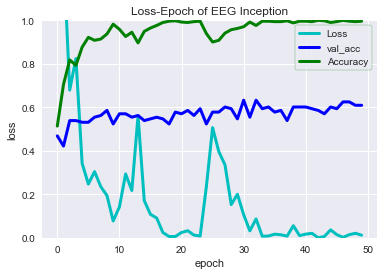

In [47]:
from keras.callbacks import ModelCheckpoint

# Reshape data_X to fit Keras model [batch, data_point, channel]
data_XT = data_X.transpose((0, 2, 1))
input_shape = data_XT.shape[0], data_XT.shape[1], data_XT.shape[2] # (800, 750, 13)
lable_shape = data_y.shape # (800, 1)

# print('Input Shape:', input_shape)
# print('Lable Shape:', lable_shape)

# 划分训练集和验证集
train_data, test_data, train_label, test_label = \
    train_test_split(data_XT, data_y, test_size=0.2, random_state = 42)

# print('Train X Shape:', train_data.shape) # (640, 750, 13)
# print('Train y Shape:', train_label.shape) # (640, 1)


# 训练模型
model = EEGInception()

# 使用 checkpoint 保存最佳模型
# checkpoint
filepath="C:/Users/1/Desktop/CNN_EEG/models/EEG_Inception_weights-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

print("========== Train and Evaluate ==========")
history = model.fit(
    train_data,
    train_label,
    batch_size = 10,
    epochs = 50,
    validation_split=0.2,
    callbacks=callbacks_list
)

# 训练记录
history.history

# Evaluate the model on the test data using `evaluate`
print("========== Evaluate on test data ==========")
results = model.evaluate(test_data, test_label, batch_size = 4)
print("test loss, test acc:", results)


# 画损失函数图
import matplotlib.pyplot as plt

plt.figure()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.style.use('seaborn')
plt.title('Loss-Epoch of EEG Inception')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim((0, 1))

plt.plot(loss, 'c-', linewidth= 3, label='Loss')
plt.plot(val_acc, 'b-', linewidth = 3, label='val_acc')
plt.plot(acc, 'g-', linewidth = 3, label='Accuracy')

plt.legend(loc='upper right',fontsize='medium',frameon=True,edgecolor='green')
plt.show()
plt.close()

#### 3.2.4 保存最佳模型

In [48]:
import tensorflow as tf

# Save Model
print("=========== Saving Model... ===========")
model.load_weights("C:/Users/1/Desktop/CNN_EEG/EEG_Inception_weights-45(0.632).hdf5")
save_filename = "C:/Users/1/Desktop/CNN_EEG"
tf.keras.models.save_model(model, save_filename)
print("=========== Best Model has Saved! ===========")

=========== Saving Model... ===========


INFO:tensorflow:Assets written to: C:/Users/1/Desktop/CNN_EEG\assets


INFO:tensorflow:Assets written to: C:/Users/1/Desktop/CNN_EEG\assets


=========== Best Model has Saved! ===========


## 4. 对测试集进行预测

### 4.1 读取测试集

In [49]:
# Read in Test Data S5~S8
import numpy as np

datafile5 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\test\S5.npz"
datafile6 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\test\S6.npz"
datafile7 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\test\S7.npz"
datafile8 = r"C:\Users\1\Desktop\CNN_EEG\Datasets\test\S8.npz"

dataSet5 = np.load(datafile5)
dataSet6 = np.load(datafile6)
dataSet7 = np.load(datafile7)
dataSet8 = np.load(datafile8)

### 4.2 载入模型进行预测

In [50]:
import tensorflow as tf

# Load Model
save_filename = "C:/Users/1/Desktop/CNN_EEG"

model = tf.keras.models.load_model(save_filename)

# Split X from Dataset
dataSet5_X = dataSet5['X']
dataSet6_X = dataSet5['X']
dataSet7_X = dataSet5['X']
dataSet8_X = dataSet5['X']

# Predict Lable using model
print('================== Predicting... ==================')

y5_predict = model.predict(dataSet5_X.transpose((0, 2, 1)))
y6_predict = model.predict(dataSet6_X.transpose((0, 2, 1)))
y7_predict = model.predict(dataSet7_X.transpose((0, 2, 1)))
y8_predict = model.predict(dataSet8_X.transpose((0, 2, 1)))

print('=============== Finish Prediction! ===============')

================== Predicting... ==================
7/7 [==============================] - 0s 6ms/step
=============== Finish Prediction! ===============


In [51]:
# Transfer Probability to Classes
def prob2class(y_predict):
    y_class = []
    for i in range(0, 200):
        if abs(1 - y5_predict[i]) > abs(y5_predict[i]):
            y_class.append(0)
        else:
            y_class.append(1)
    return y_class

In [52]:
y5_class = prob2class(y5_predict)
y6_class = prob2class(y6_predict)
y7_class = prob2class(y7_predict)
y8_class = prob2class(y8_predict)

### 4.3 将预测结果写入CSV文件

In [53]:
# 将结果写入CSV文件
import pandas as pd
import numpy as np
import csv

#字典中的key值即为csv中列名
dataframe = pd.DataFrame({'S5':y5_class,
                          'S6':y6_class,
                          'S7':y7_class,
                          'S8':y8_class,})

print(dataframe)
#将DataFrame存储为csv,index表示是否显示行名，default=True
dataframe.to_csv("C:/Users/1/Desktop/CNN_EEG/result.csv",index=False,sep=',')       #写入文件并保存
print('=============== Finish Writing in File! ===============')

     S5  S6  S7  S8
0     1   1   1   1
1     0   0   0   0
2     1   1   1   1
3     1   1   1   1
4     1   1   1   1
..   ..  ..  ..  ..
195   0   0   0   0
196   1   1   1   1
197   1   1   1   1
198   1   1   1   1
199   1   1   1   1

[200 rows x 4 columns]
=============== Finish Writing in File! ===============
